# Scaling from scratch

So we have a couple curves, of similar shape. We want to apply some function whicyh collapses them to lay on top of one another.

1. import our data
1. def collapse func:
    BKT scaling
1. def Cost function
1. mininze with respect to cost function



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy.ma as ma
from scipy.optimize import minimize, differential_evolution

## 1. import data

In [2]:
def load_IDs(L, seeds):
    Ws = np.concatenate([np.arange(1,2.6,0.2), np.arange(2.6,4.55,0.05), np.arange(4.7,6.2,0.2)])

    ID = -1*np.ones((len(seeds),len(Ws)))
    R2 = -1*np.ones((len(seeds),len(Ws)))
    
    count = 0
    missing = []
    for seed in seeds:
        try:
            data = np.atleast_2d(np.load("data/2nn_L_{0}/2nn_L_{0}_seed_{1}.npy".format(L,seed), allow_pickle=True))[0]
            ID[seed] = np.array([data[i]['ID'] for i in range(len(Ws))])
            R2[seed] = np.array([data[i]['rsquared'] for i in range(len(Ws))])
            
        except:
            missing.append(seed)
            continue
            
    ID = ma.masked_equal(ID, -1)
    print("Loaded {0} out of {1} seeds".format(len(seeds)-len(missing), len(seeds)))
    return ID, R2

In [3]:
Ws = np.concatenate([np.arange(1,2.6,0.2), np.arange(2.6,4.55,0.05), np.arange(4.7,6.2,0.2)])

ID8, R2_8 = load_IDs(8, range(0,100000))
ID10, R2_10 = load_IDs(10, range(0,10000))
ID12, R2_12 = load_IDs(12, range(0,5000))
ID14, R2_14 = load_IDs(14, range(0,1000))

Loaded 100000 out of 100000 seeds
Loaded 10000 out of 10000 seeds
Loaded 5000 out of 5000 seeds
Loaded 1000 out of 1000 seeds


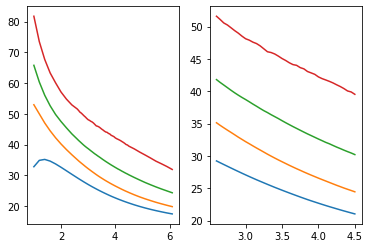

In [4]:
start, stop = 8, 47
i8 = ma.mean(ID8, axis=0)[start:stop]
i10 = ma.mean(ID10, axis=0)[start:stop]
i12 = ma.mean(ID12, axis=0)[start:stop]
i14 = ma.mean(ID14, axis=0)[start:stop]

ws = Ws[start:stop]

fig, ax = plt.subplots(1,2)
[ax[0].plot(Ws, ma.mean(ID, axis=0)) for ID in [ID8, ID10, ID12, ID14]]
[ax[1].plot(ws, i) for i in [i8, i10, i12, i14]]
ax[0].set_title('all data')
ax[1].set_title('cropped for scaling')

plt.show()

## define scaling functions + cost 

In [5]:
def x_BKT(rho, rho_c, l, alpha):
    '''This is L/epsilon'''
    return l*np.exp(-alpha/np.sqrt(abs(rho-rho_c)))

def y_func(y, l, zeta,nu):
    return np.power(l, -zeta/nu) * y

def cost_func(X):
    numerator = sum([abs(X[i+1] - X[i]) for i in range(len(X)-1)]) 
    denominator = max(X)-min(X)
    cost = numerator/denominator -1
    
    return cost

## minimize

In [128]:
def scaling(Ws, zeta, nu, alpha, rho_c):
    x = np.array([np.sign(ws-rho_c)*x_BKT(ws, rho_c, L,alpha) for L in [8,10,12,14]]).flatten()
    sorting = np.argsort(x)
    y = (np.concatenate([y_func(i8, 8, zeta, nu),
                         y_func(i10, 10, zeta, nu),
                         y_func(i12, 12, zeta, nu),
                         y_func(i14, 14, zeta, nu)])[sorting])
    return x[sorting],y, sorting
    
    

def scaling_cost(Ws, zeta, nu, alpha, rho_c):
    x,y, _ = scaling(Ws, zeta, nu, alpha, rho_c)
    return cost_func(y)
    



In [120]:
ret = differential_evolution(scaling_cost,
                             bounds=[(1,2.2),(1,2.2),(1,2.2),(3.4,3.8)], 
                             args=(1.4,1.2,2,3.8),
                            polish=True,
                             strategy='best2exp'
                            )
ret

     fun: 23.827827007134125
 message: 'Optimization terminated successfully.'
    nfev: 125
     nit: 1
 success: True
       x: array([1.54015729, 1.22376454, 1.81964644, 3.46485458])

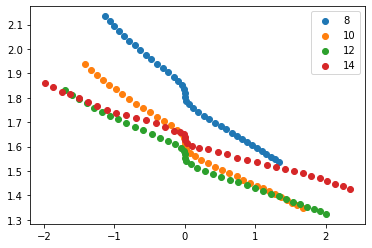

In [147]:
#View results
x,y, sorting = scaling(ws, *ret['x'])

color = np.array([[i]*(stop-start) for i in [8,10,12,14]]).flatten()[sorting]

for i in [8,10,12,14]:
    plt.scatter(x[color==i],y[color==i], label=i)
    
plt.legend()


In [75]:
strats = ['best1bin','best1exp','rand1exp','randtobest1exp','currenttobest1exp',
 'best2exp', 'rand2exp', 'randtobest1bin', 'currenttobest1bin', 'best2bin', 'rand2bin', 'rand1bin']

results = {}
for index, strat in tqdm(enumerate(strats)):
    results[strat] = []
    for i in range(100):
        ret = differential_evolution(scaling_cost,
                                 bounds=[(0,3),(0,3),(0,3),(2,5)], 
                                 args=(1.4,1.2,2,3.8),
                                polish=True,
                                )
        results[strat].append(ret['x'])
    
    

12it [05:57, 29.77s/it]


In [72]:
zeta = [np.array(results[strat])[:,0] for strat in strats]
nu = [np.array(results[strat])[:,1] for strat in strats]
alpha= [np.array(results[strat])[:,2] for strat in strats]
rho_c = [np.array(results[strat])[:,3] for strat in strats]

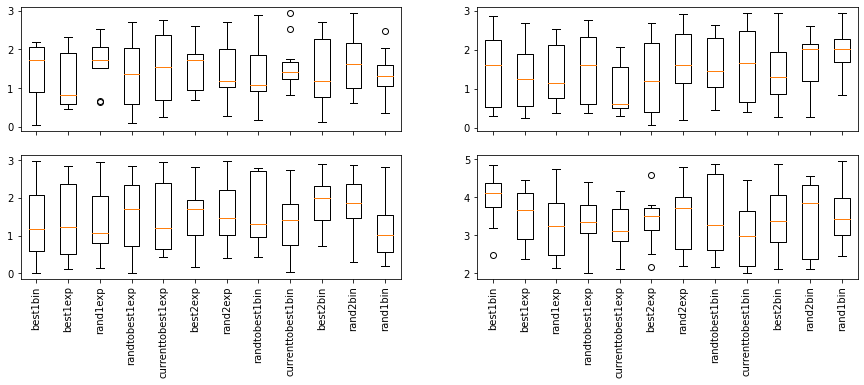

In [73]:
fig, ax = plt.subplots(2,2, figsize=(15,5), sharex=True)
ax[0,0].boxplot(zeta)
ax[0,1].boxplot(nu)
ax[1,0].boxplot(alpha)
ax[1,1].boxplot(rho_c)
ax[1,1].set_xticks(range(1,1+len(strats)),strats,rotation= 90)
ax[1,0].set_xticks(range(1,1+len(strats)),strats,rotation= 90)
plt.show()

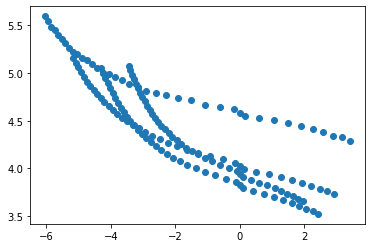

In [117]:
#View results
x,y = scaling(ws, 
              np.mean(np.array(zeta)), 
              np.mean(np.array(nu)), 
              np.mean(np.array(alpha)), 
              np.mean(np.array(rho_c)))
plt.scatter(x,y)


## can we think of another way to minimize?

1. x0
1. cost
1. vary one param up and down by one step
    1. cost
    1. choose best
1. repeat 3

In [118]:
zeta0, nu0, alpha0, rho_c0 = np.mean(np.array(zeta)), np.mean(np.array(nu)), np.mean(np.array(alpha)), np.mean(np.array(rho_c))
x = [zeta0, nu0, alpha0, rho_c0]
step = 0.001

C_lst = []

for param in tqdm(range(2000)):
    param = param%4
    zeta, nu, alpha, rho_c = x[0], x[1],x[2],x[3]
    C = scaling_cost(ws, zeta, nu, alpha, rho_c)
    x[param] += step
    zeta, nu, alpha, rho_c = x[0], x[1],x[2],x[3]
    C_up = scaling_cost(ws, zeta, nu, alpha, rho_c)
    x[param] -= 2*step
    zeta, nu, alpha, rho_c = x[0], x[1],x[2],x[3]
    C_down = scaling_cost(ws, zeta, nu, alpha, rho_c)
    
    which = np.argmin([C_down, C, C_up])
    if which == 0:
        pass
    elif which ==1:
        x[param] += step
    elif which ==2:
        x[param] += 2*step
    
    #print([C_down, C, C_up], which)
    C_lst.append([C_down, C, C_up][which]) 
x

[0.9199999999999998, 1.0809999999997884, 0.9919999999999999, 4.005000000000884]

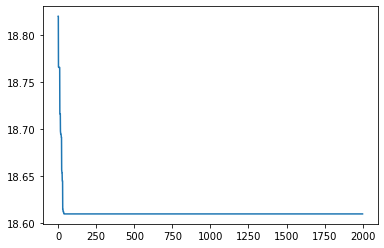

In [119]:
plt.plot(range(len(C_lst)),C_lst)

## How about with an interact function

In [123]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [148]:
def scaling_plot(zeta, nu, alpha, rho_c):
    x,y, sorting = scaling(ws, zeta, nu, alpha, rho_c)
    color = np.array([[i]*(stop-start) for i in [8,10,12,14]]).flatten()[sorting]

    for i in [8,10,12,14]:
        plt.scatter(x[color==i],y[color==i], label=i)

    plt.legend()
    

In [149]:
interact(scaling_plot, zeta=1.4, nu=1.5, alpha=1.5, rho_c=3.6);

interactive(children=(FloatSlider(value=1.4, description='zeta', max=4.199999999999999, min=-1.4), FloatSlider…